## Analyse GLM run

In [32]:
%matplotlib inline
from __future__ import division
import numpy as np
import scipy.signal as ss
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pypolyagamma import PyPolyaGamma
from math import factorial

import likelihoodfree.io as io
import likelihoodfree.viz as viz
import likelihoodfree.PDF as lfpdf
import os

## Some parameters of the analysis

In [388]:
# to save or not to save plots
save_plot_flag = 0

###############################################################################
# number of parameters inferred
num_param_inf = 10

###############################################################################
# number of repeats
seed_list = np.array([1,2,3])
num_rep = len(seed_list)

###############################################################################
# number of simulations per iteration
sim_step = 5000
num_round = 5
num_sim = np.linspace(sim_step, num_round*sim_step, num_round).astype(int)

###############################################################################
# colors
col_original = (35/255,86/255,167/255)
col_lfree = (0, 174/255,239/255)
col_samp = (244/255, 152/255, 25/255)

## Loading files

In [401]:
# loading filenames, paths and data
iw_loss_ind = 1
# preprefix_list = ['2sta_1000','2sta_1000_iwloss','2sta_1000_iwloss_alpha0']
# preprefix_list = ['2sta_1000_svi','2sta_1000_iwloss_svi','2sta_1000_iwloss_svi_alpha0']
# preprefix_list = ['2sta_1000_svi_inc_data','2sta_1000_iwloss_svi_inc_data']
preprefix_list = ['10sta_5000_svi','10sta_5000_iwloss_svi']
# preprefix_list = ['10sta_5000_svi_inc_data','10sta_5000_iwloss_svi_inc_data']
prefix = preprefix_list[iw_loss_ind]+'_seed'+str(seed_list[0])
basepath = '../results/glm/'
dir_nets = basepath + 'nets/'
dir_plots = basepath + 'plots/'
sampler_plots = basepath + 'sampler/'

# create folder for plots
if save_plot_flag:
    if not os.path.exists(dir_plots):
        os.makedirs(dir_plots)

###############################################################################
# loading data and posteriors
dists, infos, losses, nets, posteriors, sims = io.load_prefix(dir_nets, prefix)

# data
l_sims = list(sims.items())
obs_stats = l_sims[len(sims)-1][1].obs
y_obs = l_sims[len(sims)-1][1].obs_trace.reshape(-1,1)

# posterior
l_posteriors = list(posteriors.items())
posterior = l_posteriors[len(l_posteriors)-1][1]

###############################################################################
# ground-truth parameters
gt = l_sims[0][1].true_params

###############################################################################
# time
t = l_sims[0][1].t

###############################################################################
# input
I = l_sims[0][1].I_obs
I = I.reshape(1,-1)

## Sampler

In [402]:
# SIMULATION PROTOCOL:
N = 1   # Number of trials
M = num_param_inf-1   # Length of the filter

# build covariate matrix X, such that X * h returns convolution of x with filter h
X = np.zeros(shape=(len(t), M))
for j in range(M):
    X[j:,j] = I[0,0:len(t)-j]

###############################################################################
# prior: Smoothing prior on h; N(0, 1) on b0. Smoothness encouraged by penalyzing 
# 2nd order differences of elements of filter
D = np.diag(np.ones(M)) - np.diag(np.ones(M-1), -1)
F = np.dot(D, D)
# Binv is block diagonal
Binv1 = np.zeros(shape=(M+1,M+1))
Binv1[0,0] = 1    # offset (b0)
Binv1[1:,1:] = np.dot(F.T, F) # filter (h)
prior_dist = lfpdf.Gaussian(m=gt*0., P=Binv1)

BETA_sub_samp = np.load(sampler_plots + 'sampling_'+str(num_param_inf)+'sta.npy')

## Plotting modes and means

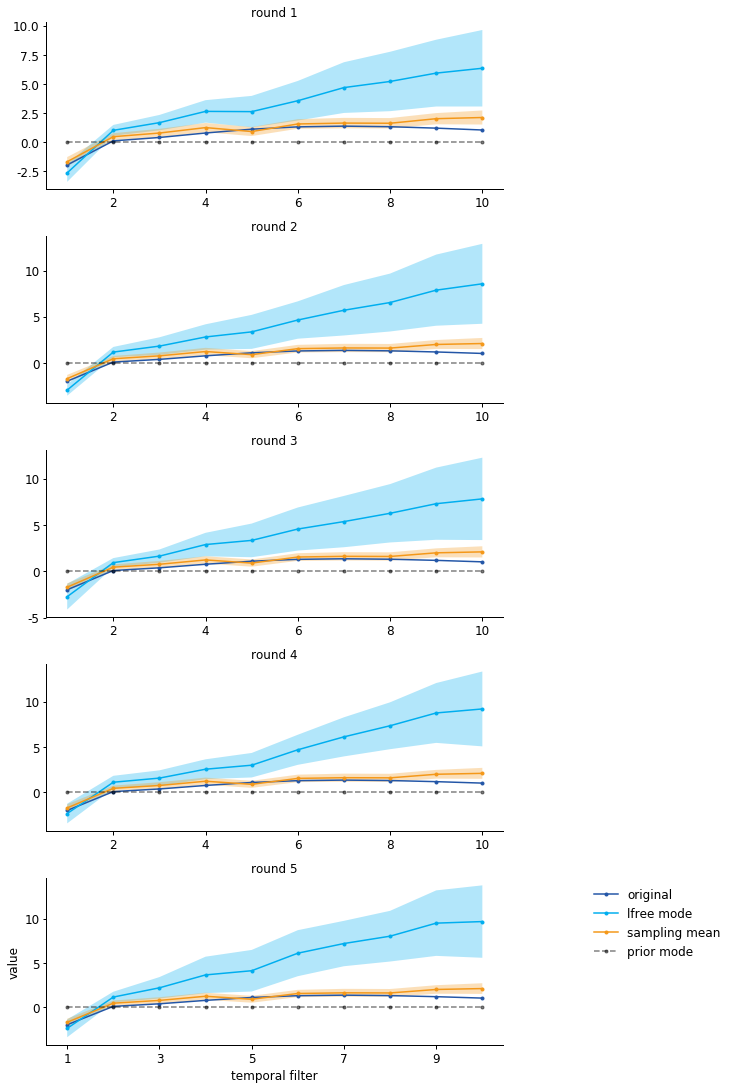

In [403]:
fig = plt.figure(figsize=(7,15))

m_samp = np.mean(BETA_sub_samp,axis=1)
cov_samp = np.cov(BETA_sub_samp)

m_all = []
S_all = []
for i in range(len(l_posteriors)):
    m, S = l_posteriors[i][1].calc_mean_and_cov()
    m_all.append(m)
    S_all.append(S)
    
    ax = plt.subplot(len(l_posteriors),1,i+1)

    plt.fill_between(np.linspace(1,num_param_inf,num_param_inf), m_all[i]-np.sqrt(np.diag(S_all[i])),
                     m_all[i]+np.sqrt(np.diag(S_all[i])),facecolor=col_lfree,alpha=0.3)
    plt.fill_between(np.linspace(1,num_param_inf,num_param_inf), m_samp-np.sqrt(np.diag(cov_samp)),
                     m_samp+np.sqrt(np.diag(cov_samp)),facecolor=col_samp,alpha=0.3)

    plt.plot(np.linspace(1,num_param_inf,num_param_inf),gt,'-o', color = col_original,
             label='original')
    plt.plot(np.linspace(1,num_param_inf,num_param_inf),m_all[i],'-o',color = col_lfree,
             label='lfree mode')
    plt.plot(np.linspace(1,num_param_inf,num_param_inf),m_samp,'-o',color = col_samp,
             label='sampling mean')
    plt.plot(np.linspace(1,num_param_inf,num_param_inf),m_all[i]*0.,'--o',color = 'k', alpha=0.5,
             label='prior mode')
    plt.title('round '+str(i+1))

plt.tight_layout()
ax.set_xticks(np.linspace(1,num_param_inf-1,int(num_param_inf/2)).astype(int))
plt.xlabel('temporal filter')
plt.ylabel('value')
plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right')


# save figure
if save_plot_flag == 1:
    plt.savefig(dir_plots + 'fig_summary_samp_lfree_modes' + prefix + '.pdf')
plt.show()

## Plotting covariances

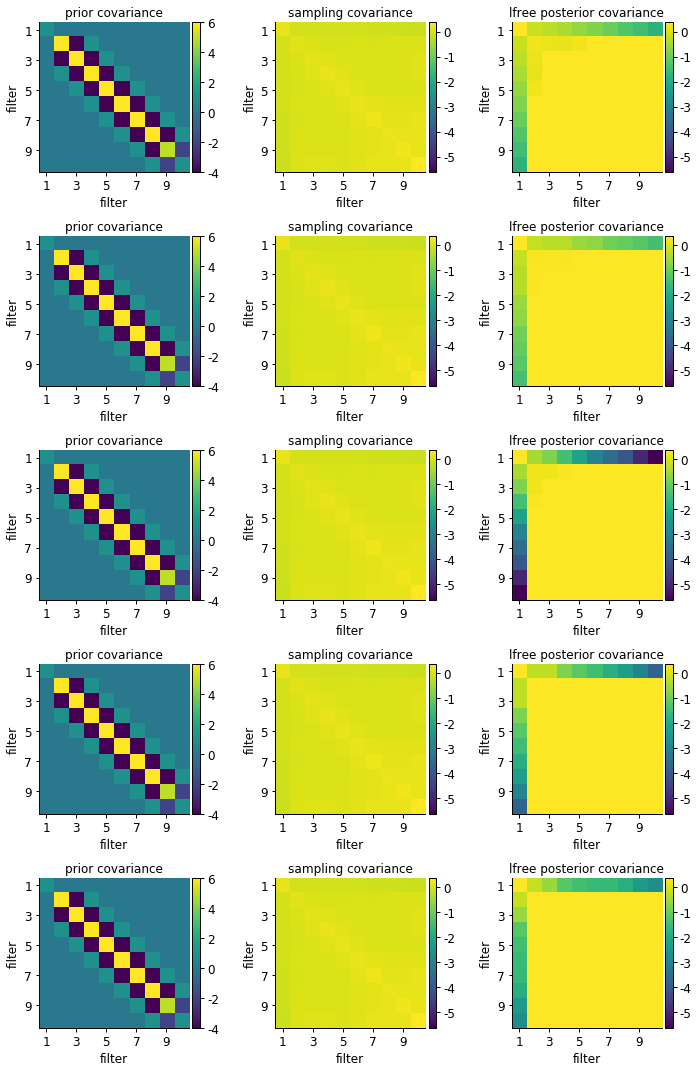

In [404]:
min_cov = np.min([np.min(cov_samp),np.min(np.asarray(S_all).reshape(-1))])
max_cov = np.min([np.max(cov_samp),np.max(np.asarray(S_all).reshape(-1))])

f, axs = plt.subplots(len(l_posteriors),3,figsize=(10,3*len(l_posteriors)))

for i in range(len(l_posteriors)):
    ax = plt.subplot(len(l_posteriors),3,3*i+1)
    im = plt.imshow(Binv1, interpolation='none')
    ax.set_xticks(np.linspace(0,num_param_inf-2,int(num_param_inf/2)).astype(int))
    ax.set_yticks(np.linspace(0,num_param_inf-2,int(num_param_inf/2)).astype(int))
    ax.set_xticklabels(np.linspace(1,num_param_inf-1,int(num_param_inf/2)).astype(int))
    ax.set_yticklabels(np.linspace(1,num_param_inf-1,int(num_param_inf/2)).astype(int))
    plt.xlabel('filter')
    plt.ylabel('filter')
    plt.title('prior covariance')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    ax = plt.subplot(len(l_posteriors),3,3*i+2)
    im = plt.imshow(cov_samp, clim=(min_cov, max_cov), interpolation='none')
    ax.set_xticks(np.linspace(0,num_param_inf-2,int(num_param_inf/2)).astype(int))
    ax.set_yticks(np.linspace(0,num_param_inf-2,int(num_param_inf/2)).astype(int))
    ax.set_xticklabels(np.linspace(1,num_param_inf-1,int(num_param_inf/2)).astype(int))
    ax.set_yticklabels(np.linspace(1,num_param_inf-1,int(num_param_inf/2)).astype(int))
    plt.xlabel('filter')
    plt.ylabel('filter')
    plt.title('sampling covariance')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    ax = plt.subplot(len(l_posteriors),3,3*i+3)
    im = plt.imshow(S_all[i], clim=(min_cov, max_cov), interpolation='none')
    ax.set_xticks(np.linspace(0,num_param_inf-2,int(num_param_inf/2)).astype(int))
    ax.set_yticks(np.linspace(0,num_param_inf-2,int(num_param_inf/2)).astype(int))
    ax.set_xticklabels(np.linspace(1,num_param_inf-1,int(num_param_inf/2)).astype(int))
    ax.set_yticklabels(np.linspace(1,num_param_inf-1,int(num_param_inf/2)).astype(int))
    plt.xlabel('filter')
    plt.ylabel('filter')
    plt.title('lfree posterior covariance')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.tight_layout()

# save figure
if save_plot_flag == 1:
    plt.savefig(dir_plots + 'fig_summary_samp_lfree_covs' + prefix + '.pdf')
plt.show()

## Analysis of stability

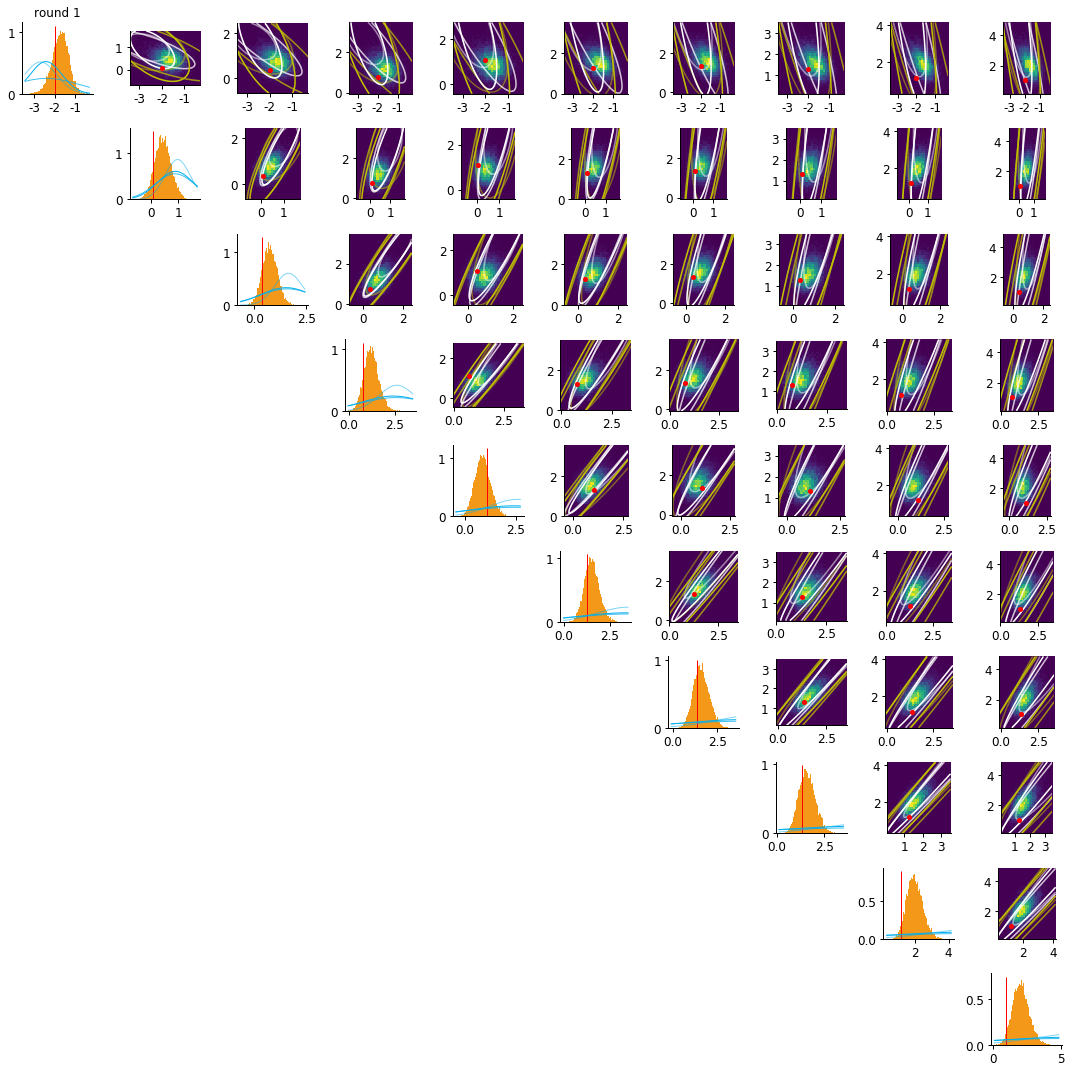

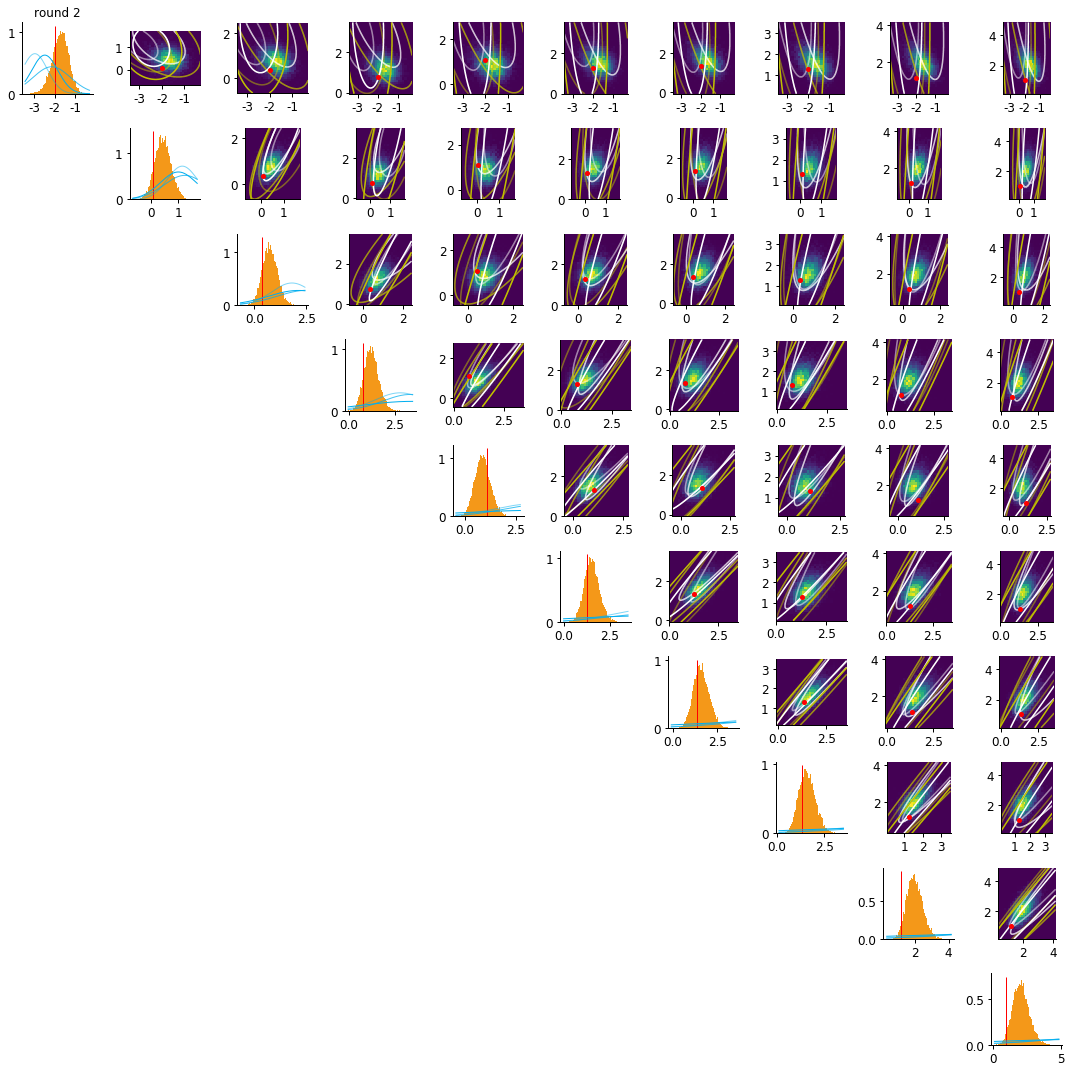

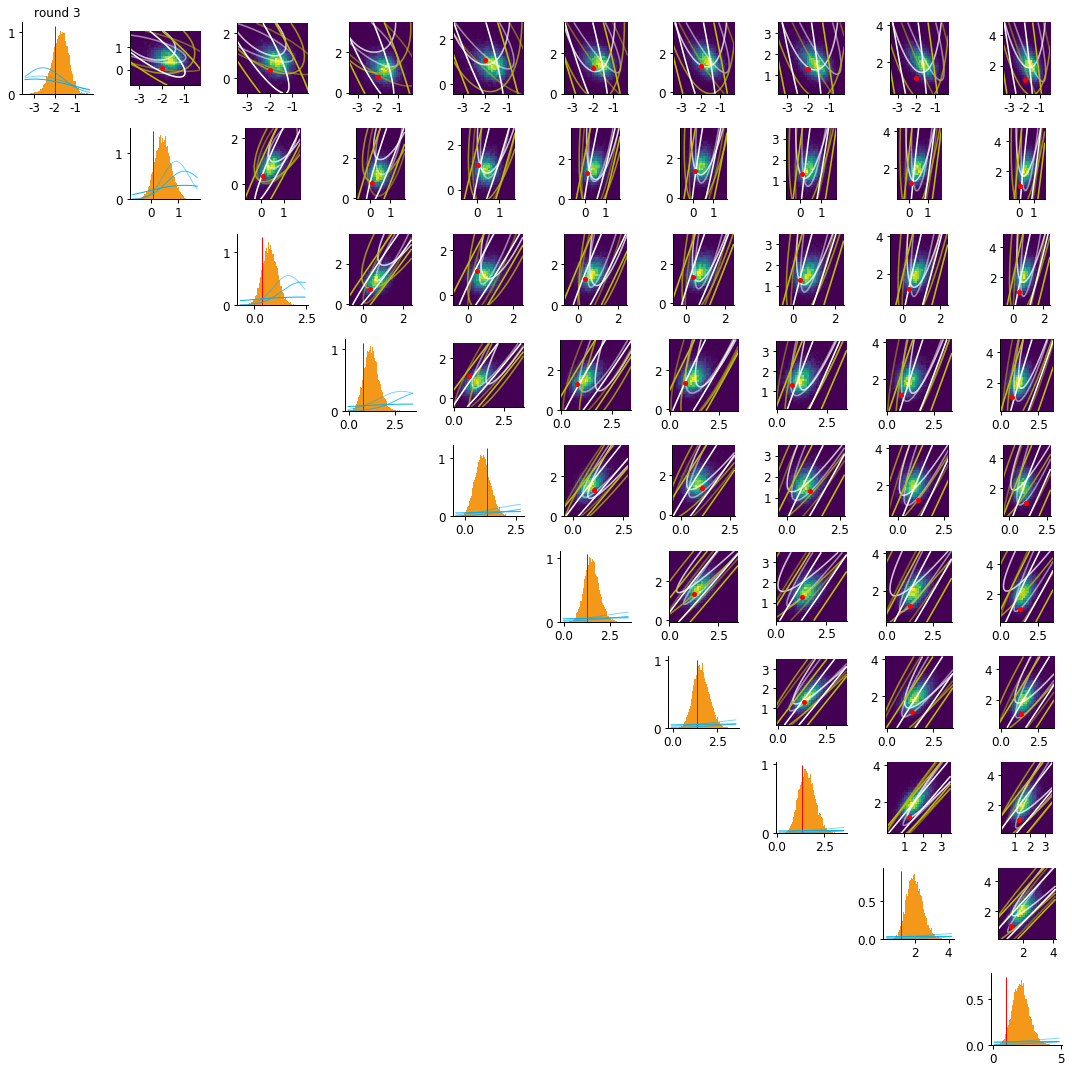

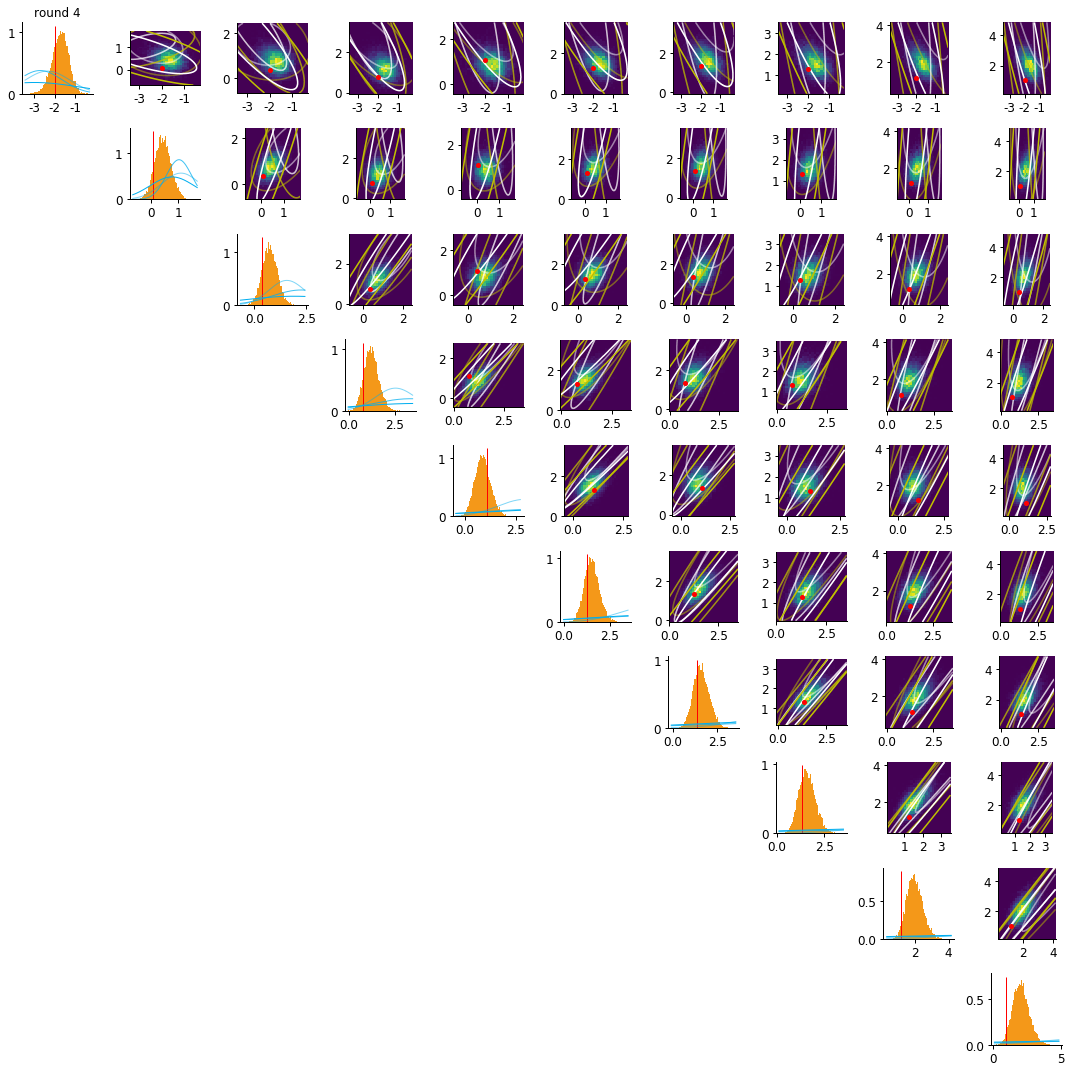

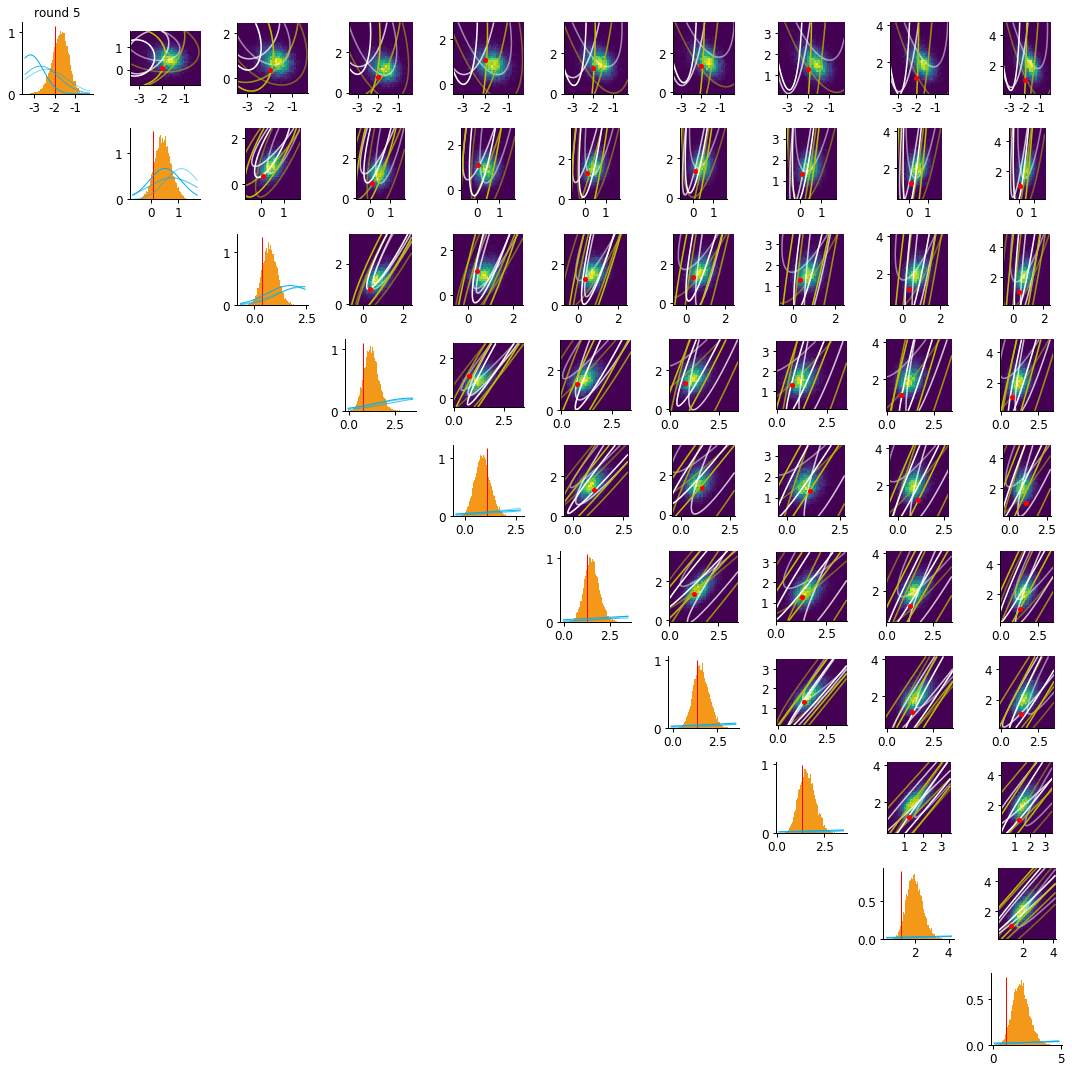

In [405]:
levels=(0.68, 0.95)

alpha_rep = np.linspace(0.5,1,num_rep)

for i in range(len(l_posteriors)):
    
    f, axs = plt.subplots(1,3,figsize=(np.maximum(5,1.5*posterior.ndim),
                                   np.maximum(5,1.5*posterior.ndim)))

    posterior_list = []
    for iii in range(0,num_rep):

        # load mdn parameters
        prefix1 = preprefix_list[iw_loss_ind]+'_seed'+str(seed_list[iii])
        _, _, _, _, posteriors, _ = io.load_prefix(dir_nets, prefix1)
        l_posteriors1 = list(posteriors.items())
        posterior = l_posteriors1[i][1]
        posterior_list.append(posterior)

    for ii in range(posterior_list[0].ndim):
        for j in range(ii,posterior_list[0].ndim):

            if ii == j:
                ax = plt.subplot2grid((posterior_list[0].ndim, posterior_list[0].ndim), (ii,j))

                samp_plot = BETA_sub_samp[ii,:]
                ax.hist(samp_plot,bins=100,normed = True,color=col_samp)

                lims = np.array([np.min(samp_plot),np.max(samp_plot)])
                xx = np.linspace(lims[0], lims[1], 500)

                for iii in range(num_rep):
                    pp = posterior_list[iii].eval(xx, ii=[ii], log=False)
                    ax.plot(xx, pp, lw=1, color=col_lfree, alpha=alpha_rep[iii])
                ax.vlines(gt[ii], 0, ax.get_ylim()[1], lw=1, color='r')
                
                if ii==0 and j==0:
                    plt.title('round '+str(i+1))

            else:
                ax = plt.subplot2grid((posterior_list[0].ndim, posterior_list[0].ndim), (ii,j))

                samp_plot_ii = BETA_sub_samp[ii,:]
                samp_plot_j = BETA_sub_samp[j,:]
                H, xedges, yedges = np.histogram2d(samp_plot_ii, samp_plot_j, bins=30,normed = True)
                ax.imshow(H.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0],
                                                       yedges[-1]],interpolation='none')

                lims = np.array([[np.min(samp_plot_ii),np.max(samp_plot_ii)],[np.min(samp_plot_j),
                                  np.max(samp_plot_j)]])
                xx = np.linspace(lims[0, 0], lims[0, 1], 500)
                yy = np.linspace(lims[1 ,0], lims[1, 1], 500)
                X, Y = np.meshgrid(xx, yy)
                xy = np.concatenate([X.reshape([-1, 1]), Y.reshape([-1, 1])], axis=1)

                for iii in range(num_rep):
                    pp = posterior_list[iii].eval(xy, ii=[ii, j], log=False)
                    pp = pp.reshape(list(X.shape))
                    ax.contour(X, Y, viz.probs2contours(pp, levels), levels, lw=1,
                               colors=('w','y'),alpha=alpha_rep[iii])
                ax.set_xlim(lims[0])
                ax.set_ylim(lims[1])
                ax.plot(gt[ii], gt[j], 'r.', ms=8)
    
    plt.tight_layout()

# save figure
if save_plot_flag == 1:
    plt.savefig(dir_plots + 'fig_summary_samp_lfree_stability' + preprefix_list[iw_loss_ind] + '.pdf')
plt.show()

## Analysis of convergence

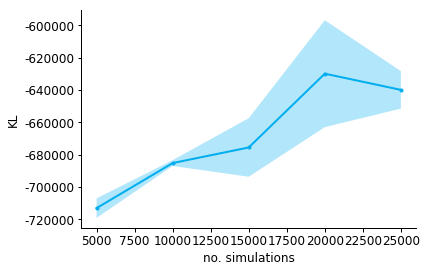

In [406]:
fig = plt.figure()

############################
# GLM log-likelihood for all samples
# binomial coefficient
bin_coeff_t = np.zeros_like(t)
for j in range(len(t)):
    bin_coeff_t[j] = np.log(factorial(N)/(factorial(y_obs[j,0])*factorial(N-y_obs[j,0])))
bin_coeff = np.sum(bin_coeff_t)

# additional two terms of likelihood
y_psi = np.dot(obs_stats,BETA_sub_samp)
psi = np.zeros((len(t),len(BETA_sub_samp[0,:])))
for j in range(len(BETA_sub_samp[0,:])):
    psi[:,j] = BETA_sub_samp[0,j] + ss.lfilter(BETA_sub_samp[1:,j], 1, I.T, axis=0)[:,0]
C = N*np.sum(np.log(1+np.exp(psi)),0)

log_likel_samp = bin_coeff+y_psi-C

############################
# GLM log-posterior (up to the constant log p(data)) for all samples: log(prior)+log(likelihood)
log_prior_samp = prior_dist.eval(BETA_sub_samp.T, log=True)
log_post_samp = np.sum(log_likel_samp+log_prior_samp)


kl_approx = np.zeros((num_rep,len(num_sim)))
for iii in range(num_rep):
    # load all iterations of iii inference
    prefix1 = preprefix_list[iw_loss_ind]+'_seed'+str(seed_list[iii])
    _, _, _, _, posteriors, _ = io.load_prefix(dir_nets, prefix1)
    l_posteriors1 = list(posteriors.items())
    
    for jjj in range(len(num_sim)):
        # compute KL for each jjj iteration of iii inference
        posterior = l_posteriors1[jjj][1]
        pp = posterior.eval(BETA_sub_samp.T, log=False)
        kl_approx[iii,jjj] = log_post_samp - np.sum(np.log(pp))


kl_approx_mn = np.mean(kl_approx,0)
kl_approx_std = np.std(kl_approx,0)
plt.fill_between(num_sim, kl_approx_mn-kl_approx_std,
                 kl_approx_mn+kl_approx_std,facecolor=col_lfree,alpha=0.3)
plt.plot(num_sim,kl_approx_mn,'o-', lw=2, color=col_lfree)
plt.xlabel('no. simulations')
plt.ylabel('KL')

# save figure
if save_plot_flag == 1:
    plt.savefig(dir_plots + 'fig_summary_samp_lfree_convergence' + preprefix_list[iw_loss_ind] + '.pdf')
plt.show()

## Training loss

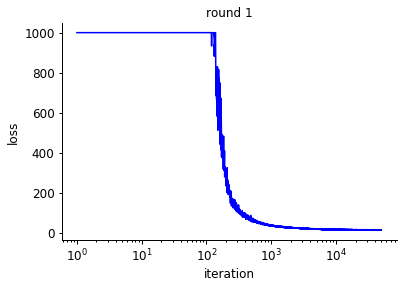

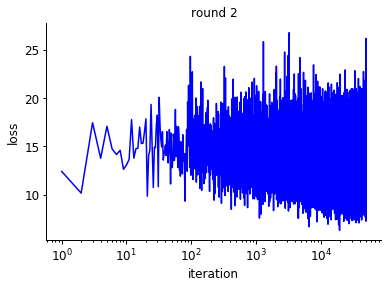

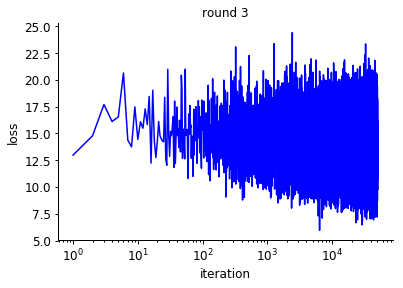

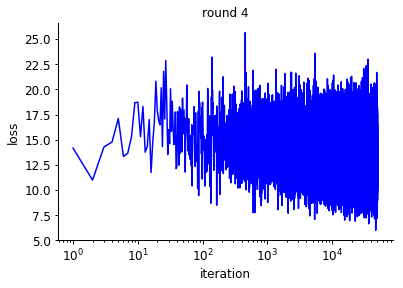

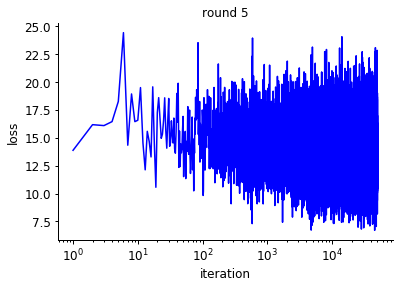

In [407]:
i=0
for k, v in losses.items():
    i = i+1
    fig, ax = viz.loss(v, title=k)
#     plt.show()
    plt.title('round '+str(i))

## Distance of samples

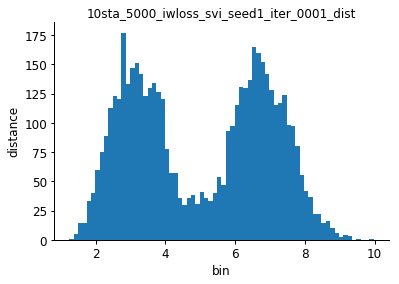

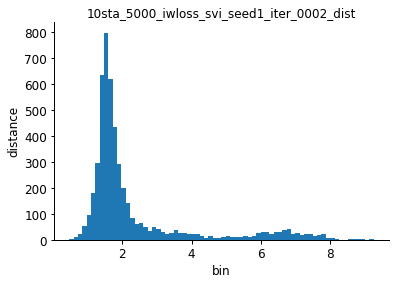

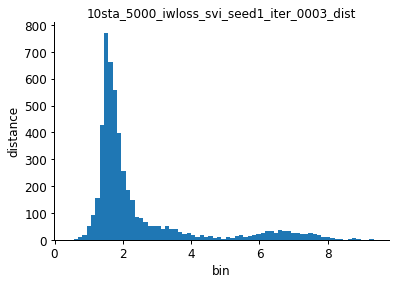

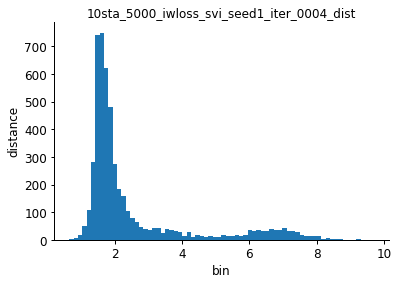

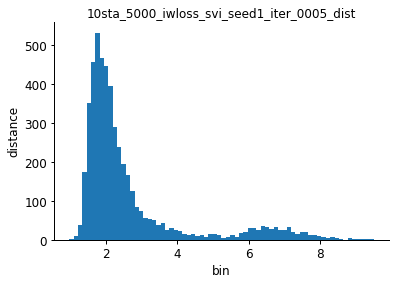

In [408]:
for k, v in dists.items():
    fig, ax = viz.dist(v, title=k)

## Validation set

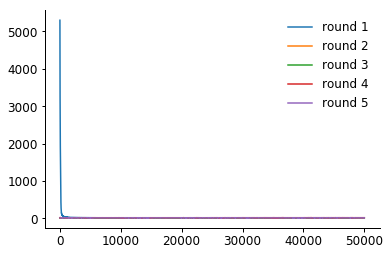

In [409]:
for i in range(num_round):
    plt.plot(io.nth(losses, i)['val_val'],label='round '+str(i+1))
plt.legend()

## Importance weights

/Applications/anaconda/lib/python3.5/site-packages/matplotlib/axes/_base.py:3179: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))
/Applications/anaconda/lib/python3.5/site-packages/matplotlib/axes/_base.py:3179: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=100.0, top=100.0
  'bottom=%s, top=%s') % (bottom, top))


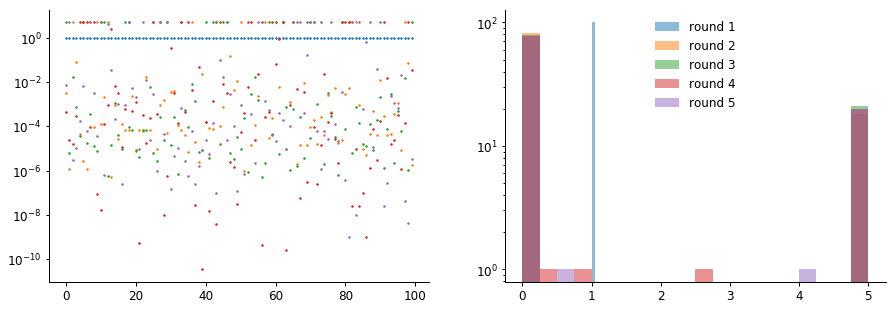

In [410]:
f, axs = plt.subplots(1,2,figsize=(15,5))

for i in range(num_round):    
    ax = plt.subplot(1,2,1)
    plt.semilogy(io.nth(losses, i)['trn_out'][-1][1],'.')
    
    ax = plt.subplot(1,2,2)
    plt.hist(io.nth(losses, i)['trn_out'][-1][1],bins=20,log=True,alpha=0.5,label='round '+str(i+1))

plt.legend()

In [411]:
len(io.nth(losses, i)['trn_out'][-1][1])

100

## Info

In [412]:
for k, v in infos.items():
    print(viz.info(v, title=k))

10sta_5000_iwloss_svi_seed1_iter_0001_info
n_components : 1
git_revision_hash : b'1b38cc8b0cb7141faf44e3caf603da346dc58e29\n'
reg_scale : 1.0
n_samples_val : 100
datetime : 2017-05-02 16:10:18.749163
act_fun : tanh
n_hiddens : [50]
n_outputs : 10
prior_proposal : None
tol_val : None
observe : weights
pruning : False
prior_true : <likelihoodfree.PDF.Gaussian object at 0x136107da0>
prefix : 10sta_5000_iwloss_svi_seed1
n_samples : 5000
reg_lambda : 0.01
n_monitor_freq : 1
rnn_hiddens : None
reg_scale_iw : False
runtime : 234.9869818687439
load_val : None
n_iter : 1000
loss_calib : None
reg_init : False
svi : True
n_inputs : 10
load_trn : None
iw_loss : True
seed : 1
n_minibatch : 100
postfix : iter_0001
reg_scale_lc : False
errors : 
tol : None
prior_alpha : None

10sta_5000_iwloss_svi_seed1_iter_0002_info
n_components : 1
git_revision_hash : b'1b38cc8b0cb7141faf44e3caf603da346dc58e29\n'
reg_scale : 1.0
n_samples_val : 100
datetime : 2017-05-02 16:15:02.349577
act_fun : tanh
n_hiddens : [